<a href="https://colab.research.google.com/github/Kerebel/tp-information-retrieval-with-llm-student-version/blob/main/2-Recherche%20d'information%20sémantique.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Partie 2. - Recherche d'Information sémantique

Les recherches réalisées dans le TP précédent sont principalement des recherches par mots ou par phrases basés sur le modèle `tf-idf`. Ce dernier construit un espace vectoriel dont la taille est égal au nombre total de tokens distincts dans la collection de documents. L'image ci-dessous représente un espace vectoriel avec 3 tokens distincts. Imaginez ce que cela donnerait avec 100,000 tokens distincts !

![tf-df-vector-space](https://github.com/Kerebel/tp-information-retrieval-with-llm-student-version/blob/main/resources/tfidf-vector-space.png?raw=1)

Certes, des techniques existent pour limiter l'impact des variations syntaxiques (bas/haut de casses, mots au pluriel/singulier, synonymes) mais cela pose plusieurs problèmes :
- effort requis pour paramétrer minutieusement la construction des tokens ;
- recourt à des dictionnaires, notamment pour les synonymes ;
- prise en compte des points précédents pour différentes langues ;
- sens d'une phrase, paragraphe, document non pris en compte dans sa globalité.

Pour palier ces problèmes, on peut utiliser des techniques avancées de Traitement Automatique du Langage Naturel (TALN) pour construire des espaces vectoriels _sémantiques_ où les mots, paragraphes, documents sont représentés par des vecteurs, appelés _embeddings_, encodant le sens des informations plutôt que leur syntaxe. Les espace vectoriels associés ont une taille fixe, de quelques centaines de dimensions. Ci-dessous un exemple de ce type d'espace en 2 dimensions (source : https://dev.to/jinglescode/word-embeddings-16hb)

![embeddings](https://github.com/Kerebel/tp-information-retrieval-with-llm-student-version/blob/main/resources/embeddings_2d.png?raw=1)

Grâce aux _modèles de langue_, notamment aux _transformers_ (https://arxiv.org/abs/1706.03762) pré-entraînés et proposés librement par des sociétés comme Google, OpenAI, Facebook, il est maintenant possible de construire ses propres _embeddings_ sur n'importe quel texte.

Huggingface (https://huggingface.co/) est une plateforme proposant nombre de ces modèles pré-entraînés, en particulier des modèles de type _transformers_ que l'on peut utiliser sur nos propres données : https://huggingface.co/sentence-transformers.

Dans ce TP, nous allons utiliser l'un de ces modèles pour construire un _embedding_ par document et nous permettre de faire des recherches sémantiques et de trouver des documents similaires.

En sortie de ce module, vous serez capable de :

- Calculer l'_embedding_ d'un texte, c'est à dire sa représentation sémantique. En fonction du modèle choisi pour calculer les embeddings, ces derniers peuvent même être multilangues !
- Rechercher des documents de manière plus pertinentes grâce à la recherchs sémantique ;
- Mettre en oeuvre un système de Question / Réponse en utilisant la méthologie _Retrieval Augmented Generation (RAG)_

### Instruction à suivre pour exécution sur Google Colab

Aller dans `Execution -> Modifier le type d'exécution` puis sélectionner `T4-GPU` pour exploiter les fonctionnalités GPU.

![Colab GPU](resources/colab_gpu.png "T4-GPU")


### Import des bibliothèques logicielles et configuration

In [2]:
import os

# Vérifie si le code est exécuté sur Google Colab
if 'COLAB_GPU' in os.environ:
    # Commandes à exécuter uniquement sur Google Colab
    !git clone https://github.com/Kerebel/tp-information-retrieval-with-llm-student-version.git
    %cd tp-information-retrieval-with-llm-student-version
    !pip install -r requirements.txt
else:
    # Commandes à exécuter si ce n'est pas sur Google Colab
    print("Pas sur Google Colab, ces commandes ne seront pas exécutées.")

Cloning into 'tp-information-retrieval-with-llm-student-version'...
remote: Enumerating objects: 2255, done.
remote: Counting objects: 100% (43/43), done.
remote: Compressing objects: 100% (26/26), done.
remote: Total 2255 (delta 25), reused 31 (delta 17), pack-reused 2212
Receiving objects: 100% (2255/2255), 13.92 MiB | 19.77 MiB/s, done.
Resolving deltas: 100% (27/27), done.
/content/tp-information-retrieval-with-llm-student-version/tp-information-retrieval-with-llm-student-version
  Using cached openai-1.3.0-py3-none-any.whl (220 kB)
  Using cached langchain-0.0.336-py3-none-any.whl (2.0 MB)
  Using cached sentence-transformers-2.2.2.tar.gz (85 kB)
  Preparing metadata (setup.py) ... done
  Using cached chromadb-0.4.17-py3-none-any.whl (496 kB)
  Using cached unstructured-0.10.30-py3-none-any.whl (1.7 MB)
  Using cached accelerate-0.24.1-py3-none-any.whl (261 kB)
  Using cached bitsandbytes-0.41.2.post2-py3-none-any.whl (92.6 MB)
  Using cached gradio-3.48.0-py3-none-any.whl (20.3 M

In [3]:
from langchain.document_loaders import DirectoryLoader
from langchain.text_splitter import RecursiveCharacterTextSplitter
from langchain.embeddings import SentenceTransformerEmbeddings
from langchain.vectorstores import Chroma
import locale
locale.getpreferredencoding = lambda: "UTF-8"

### Lecture des données

Ce premier bloc permet de lire les données. Grâce à [langchain](https://python.langchain.com/docs/get_started/introduction), lire des données est très facile et cela ne requiert que quelques lignes de codes.

Etudier la document [Document loaders](https://python.langchain.com/docs/modules/data_connection/document_loaders/) pour en apprendre plus sur la lecture des données

In [4]:
directory = './data_bbc_news/'

def load_docs(directory):
  loader = DirectoryLoader(directory)
  documents = loader.load()
  return documents

documents = load_docs(directory)
print('{} documents lus.'.format(len(documents)))

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.


2225 documents lus.


### Découpage des documents

Les modèles _sentence transformers_ ne prennent qu'un nombre limité de tokens en entrée. C'est pourquoi il est nécessaire de découper les documents en plusieurs blocs. Ce découpage présente aussi l'avantage d'être plus précis dans la recherche et de ne cibler que les paragraphes les plus pertinents pour une recherche.

Le bloc ci-dessous réalise ce découpage.

In [5]:
def split_docs(documents,chunk_size=10000,chunk_overlap=20):
  text_splitter = RecursiveCharacterTextSplitter(chunk_size=chunk_size, chunk_overlap=chunk_overlap)
  docs = text_splitter.split_documents(documents)
  return docs

paragraphs = split_docs(documents)
print('{} documents découpés en {} blocs.'.format(len(documents), len(documents)))

2225 documents découpés en 2225 blocs.


### Chargement du modèle _sentence transformer_

La ligne ci-dessous permet de charger un modèle _sentence transformer_ permettant d'encoder un bloc de texte en un _embedding_, c'est à dire un vecteur de réels de taille fixe. Le modèle est automatiquement téléchargé sur la plateforme [Huggingface](https://huggingface.co).

Jetez un oeil à la documentation des _sentence transformers_ ici : https://www.sbert.net/

Certains modèle comme [celui-ci](https://huggingface.co/intfloat/multilingual-e5-base) sont multi langues.

Vous pouvez remplacer le modèle par défaut par un autre modèle. Une liste de modèle est disponible ici https://huggingface.co/models?pipeline_tag=sentence-similarity&sort=downloads


#### Exercice 1

Dans la liste des modèle disponible ici https://huggingface.co/models?pipeline_tag=sentence-similarity&sort=downloads :
- Rechercher le modèle `intfloat/multilingual-e5-base`.
- Enlisant la documentation sur la page, spécifier la valeur du paramètre `model_name` avec le modèle trouvé.

In [7]:
embeddings = SentenceTransformerEmbeddings(model_name="intfloat/multilingual-e5-base")

(…)4899c414143008918db3fe2c8/.gitattributes:   0%|          | 0.00/1.53k [00:00<?, ?B/s]

(…)4143008918db3fe2c8/1_Pooling/config.json:   0%|          | 0.00/200 [00:00<?, ?B/s]

(…)246224899c414143008918db3fe2c8/README.md:   0%|          | 0.00/179k [00:00<?, ?B/s]

(…)6224899c414143008918db3fe2c8/config.json:   0%|          | 0.00/694 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/1.11G [00:00<?, ?B/s]

(…)99c414143008918db3fe2c8/onnx/config.json:   0%|          | 0.00/686 [00:00<?, ?B/s]

model.onnx:   0%|          | 0.00/1.11G [00:00<?, ?B/s]

sentencepiece.bpe.model:   0%|          | 0.00/5.07M [00:00<?, ?B/s]

(…)918db3fe2c8/onnx/special_tokens_map.json:   0%|          | 0.00/280 [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/17.1M [00:00<?, ?B/s]

(…)08918db3fe2c8/onnx/tokenizer_config.json:   0%|          | 0.00/418 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/1.11G [00:00<?, ?B/s]

(…)008918db3fe2c8/sentence_bert_config.json:   0%|          | 0.00/57.0 [00:00<?, ?B/s]

sentencepiece.bpe.model:   0%|          | 0.00/5.07M [00:00<?, ?B/s]

(…)43008918db3fe2c8/special_tokens_map.json:   0%|          | 0.00/280 [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/17.1M [00:00<?, ?B/s]

(…)4143008918db3fe2c8/tokenizer_config.json:   0%|          | 0.00/418 [00:00<?, ?B/s]

(…)224899c414143008918db3fe2c8/modules.json:   0%|          | 0.00/387 [00:00<?, ?B/s]

### Indexation des documents dans la BDD vectorielle _ChromaDB_

[ChromaDB](https://www.trychroma.com/) est une base de données vectorielle, un _Vector Store_. Elle permet de stocker des _embeddings_ pour des textes mais aussi pour des images et des fichiers audios.

La ligne ci-dessous permet d'indexer les paragraphes calculés ci-dessus dans la base ChromaDB en utilisant le modèle _sentence transformer_ préalablement chargé.

In [8]:
chromadb_dir = "./chromadb" # Chemin où seront stockées les données
db = Chroma.from_documents(paragraphs, embeddings, persist_directory=chromadb_dir)

### Interrogation

Interroger les documents est une étape simple pour l'utilisateur, même si les mécanismes sous-jacents restent complexes.

La ligne ci-dessous permet de rechercher les documents similaire à la requête `query`.

#### Exercice 2

En lisant la documentation ici https://python.langchain.com/docs/integrations/vectorstores/chroma :
- Rechercher les documents similaires à la requête `query`
- Afficher les 5 documents les plus pertinents

In [10]:
query = "Jeux vidéo Playstation"
matching_docs = db.similarity_search(query)

# Affice les 5 résultats les plus pertinents

### Chatbot en mode RAG

Dans cette partie, nous mettons en oeuvre un chatbot en utilisant un _Large Language Model_ qui va se servir des documents trouvés dans la BDD vectorielle pour synthétiser et les informations et construire une réponse.

Nous pourrions utiliser GPT3.5 ou GPT4 mais pour des raisons de coût (il faut un abonnement payant), nous allons utiliser un petit modèle open source [llama2](https://ai.meta.com/llama/).

Nous allons même réaliser une petite IHM du chatbot avec la bibliothèque [gradio](https://www.gradio.app/).

#### Import des bibliothèques

In [11]:

import transformers
import gradio as gr

from textwrap import fill
from IPython.display import Markdown, display

from langchain.prompts.chat import (
    ChatPromptTemplate,
    HumanMessagePromptTemplate,
    SystemMessagePromptTemplate,
    )

from langchain import PromptTemplate
from langchain import HuggingFacePipeline

from langchain.vectorstores import Chroma
from langchain.schema import AIMessage, HumanMessage
from langchain.memory import ConversationBufferMemory
from langchain.embeddings import HuggingFaceEmbeddings
from langchain.text_splitter import RecursiveCharacterTextSplitter
from langchain.document_loaders import UnstructuredMarkdownLoader, UnstructuredURLLoader
from langchain.chains import LLMChain, SimpleSequentialChain, RetrievalQA, ConversationalRetrievalChain

from transformers import BitsAndBytesConfig, AutoModelForCausalLM, AutoTokenizer, GenerationConfig, pipeline


#### Configuration du LLM

Dans cette partie, nous allons utiliser le modèle [llamav2](https://huggingface.co/NousResearch/Llama-2-7b-chat-hf) dôté de 7 milliards de paramètres. C'est le plus petit des trois modèles de l'organisation puisqu'il y a ensuite les modèles de 13 et 70 milliards de paramètres.

Le modèle est automatiquement téléchargé sur la plateforme [Huggingface](https://huggingface.co).

In [12]:
llm_model_id = "NousResearch/Llama-2-7b-chat-hf"

# Chargement de la configuration
model_config = transformers.AutoConfig.from_pretrained(
    llm_model_id
)

# Chargement du modèle LLM
model = transformers.AutoModelForCausalLM.from_pretrained(
    llm_model_id,
    trust_remote_code=True,
    config=model_config,
    device_map='auto',
    load_in_8bit=True,
)

# Chargement du tokenizer
tokenizer = AutoTokenizer.from_pretrained(llm_model_id)

# Configuration de la génération
generation_config = GenerationConfig.from_pretrained(llm_model_id)
generation_config.max_new_tokens = 1024
generation_config.temperature = 0.0001 # plus la température est basse, plus les prédictions sont précises
generation_config.top_p = 0.95
generation_config.do_sample = True
generation_config.repetition_penalty = 1.15

# Création du pipeline
pipeline = pipeline(
    "text-generation",
    model=model,
    tokenizer=tokenizer,
    return_full_text=True,
    generation_config=generation_config,
)

# Création du pipeline LLM
llm = HuggingFacePipeline(
    pipeline=pipeline,
)

(…)ma-2-7b-chat-hf/resolve/main/config.json:   0%|          | 0.00/583 [00:00<?, ?B/s]

(…)esolve/main/model.safetensors.index.json:   0%|          | 0.00/26.8k [00:00<?, ?B/s]

model-00001-of-00002.safetensors:   0%|          | 0.00/9.98G [00:00<?, ?B/s]

model-00002-of-00002.safetensors:   0%|          | 0.00/3.50G [00:00<?, ?B/s]

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

(…)t-hf/resolve/main/generation_config.json:   0%|          | 0.00/179 [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/transformers/generation/configuration_utils.py:381: UserWarning: `do_sample` is set to `False`. However, `temperature` is set to `0.9` -- this flag is only used in sample-based generation modes. You should set `do_sample=True` or unset `temperature`. This was detected when initializing the generation config instance, which means the corresponding file may hold incorrect parameterization and should be fixed.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/generation/configuration_utils.py:386: UserWarning: `do_sample` is set to `False`. However, `top_p` is set to `0.6` -- this flag is only used in sample-based generation modes. You should set `do_sample=True` or unset `top_p`. This was detected when initializing the generation config instance, which means the corresponding file may hold incorrect parameterization and should be fixed.
  warnings.warn(


(…)at-hf/resolve/main/tokenizer_config.json:   0%|          | 0.00/746 [00:00<?, ?B/s]

tokenizer.model:   0%|          | 0.00/500k [00:00<?, ?B/s]

(…)2-7b-chat-hf/resolve/main/tokenizer.json:   0%|          | 0.00/1.84M [00:00<?, ?B/s]

(…)b-chat-hf/resolve/main/added_tokens.json:   0%|          | 0.00/21.0 [00:00<?, ?B/s]

(…)-hf/resolve/main/special_tokens_map.json:   0%|          | 0.00/435 [00:00<?, ?B/s]

#### Création du _prompt template_

Un prompt template permet de configurer la manière dont le LLM doit se comporter. Grâce à la bibliothèque [langchain](https://www.langchain.com/), la création d'un _prompt template_ est simplifiée et permet notamment d'inclure des variables quis seront spécifiées plus tard, lors de l'exécution de la chaîne.

Dans l'exemple ci-dessous, le template est rédigé en anglais car la majeure partie des documents sur lesquels le LLM a été entraîné sont en anglais. La performance est meilleur qu'en français.

#### Exercice 3

Modifier le `prompt_template` pour indiquer dans le bloc `[INST]` les instructions nécessaire pour que le LLM :
- Agisse comme un journaliste
- Répondre à la question en utilisant seulement les éléments du contexte et rien d'autres
- Cite les paragraphes pertinents qui ont permis de répondre à la questions

Ces instructions doivent être écrites en anglais.

In [13]:
prompt_template = """
[INST]
To act as a journalist, respond to the question using only elements from the context provided. Ensure that the response is solely based on the context without adding any external information.
When citing, include the relevant paragraphs from the context that directly contribute to your response.
[/INST]

[CONTEXT]
{context}
[/CONTEXT]

[QUESTION]
{question}
[/QUESTION]

[CITATION]
Please cite specific passages from the above context that were particularly relevant in answering the question.
[/CITATION]

[RESPONSE]
[/RESPONSE]
"""

prompt = PromptTemplate(template=prompt_template, input_variables=["context", "question"])

#### Configuration de la chaîne de Question/Réponse

Les lignes ci-dessous permettent de configurer le système de Question Réponse. Dans cet exemple, le système récupère les 2 paragraphes les plus pertinents (`"k":2`) pour construire la réponse. Il est possible d'augmenter ce nombre mais cela demandera plus de temps pour construire la réponse.

In [17]:
qa_chain = RetrievalQA.from_chain_type(
    llm=llm, # LLM utilisé, en l'occrurence llamav2 7B
    chain_type="stuff", # Type de chaîne à utiliser
    retriever=db.as_retriever(search_kwargs={"k": 2}), # récupérateur des k documents les plus pertinents
    return_source_documents=True, # retourne les documents sources
    chain_type_kwargs={"prompt": prompt}, # prompt à utiliser
)

#### IHM du chatbot avec gradio

Les quelques lignes ci-dessous permettent de construire l'IHM du chatbot qui sera accessible depuis un navigateur Web. Depuis google colab, un lien générique durant 24H est généré automatiquement.

In [18]:
def ask(question, history):
    response = qa_chain(
      question
    )
    return response["result"].strip()

interface = gr.ChatInterface(
    fn = ask,
    chatbot=gr.Chatbot(height=600),
    textbox=gr.Textbox(placeholder="What is quantum computing?", container=False, scale=7),
    title="CNAM ChatBot",
    theme="soft",
    examples=["What is quantum computing?"],

    cache_examples=True,
    retry_btn="Relancer",
    undo_btn="Annuler",
    clear_btn="Réinitialiser",
    submit_btn="Envoyer"

    )

interface.launch(share=True)

Caching examples at: '/content/tp-information-retrieval-with-llm-student-version/tp-information-retrieval-with-llm-student-version/gradio_cached_examples/35'
Caching example 1/1
Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
Running on public URL: https://153b0888bfde1f2f26.gradio.live

This share link expires in 72 hours. For free permanent hosting and GPU upgrades, run `gradio deploy` from Terminal to deploy to Spaces (https://huggingface.co/spaces)


#### Exercice 4.

En utilisant le chatbot construit, indiquer ci-dessous les réponses aux questions ci-après.

#### Quelques exemples de questions à poser

- Who is Dr Mario Paniccia?
- What celebrity opens February's Super Bowl?
- What is the primary objective of the upcoming meeting of military chiefs regarding Scotland's Army regiments?
- What injury did Chris Tomlinson sustain, and how has it affected his training and competition plans?

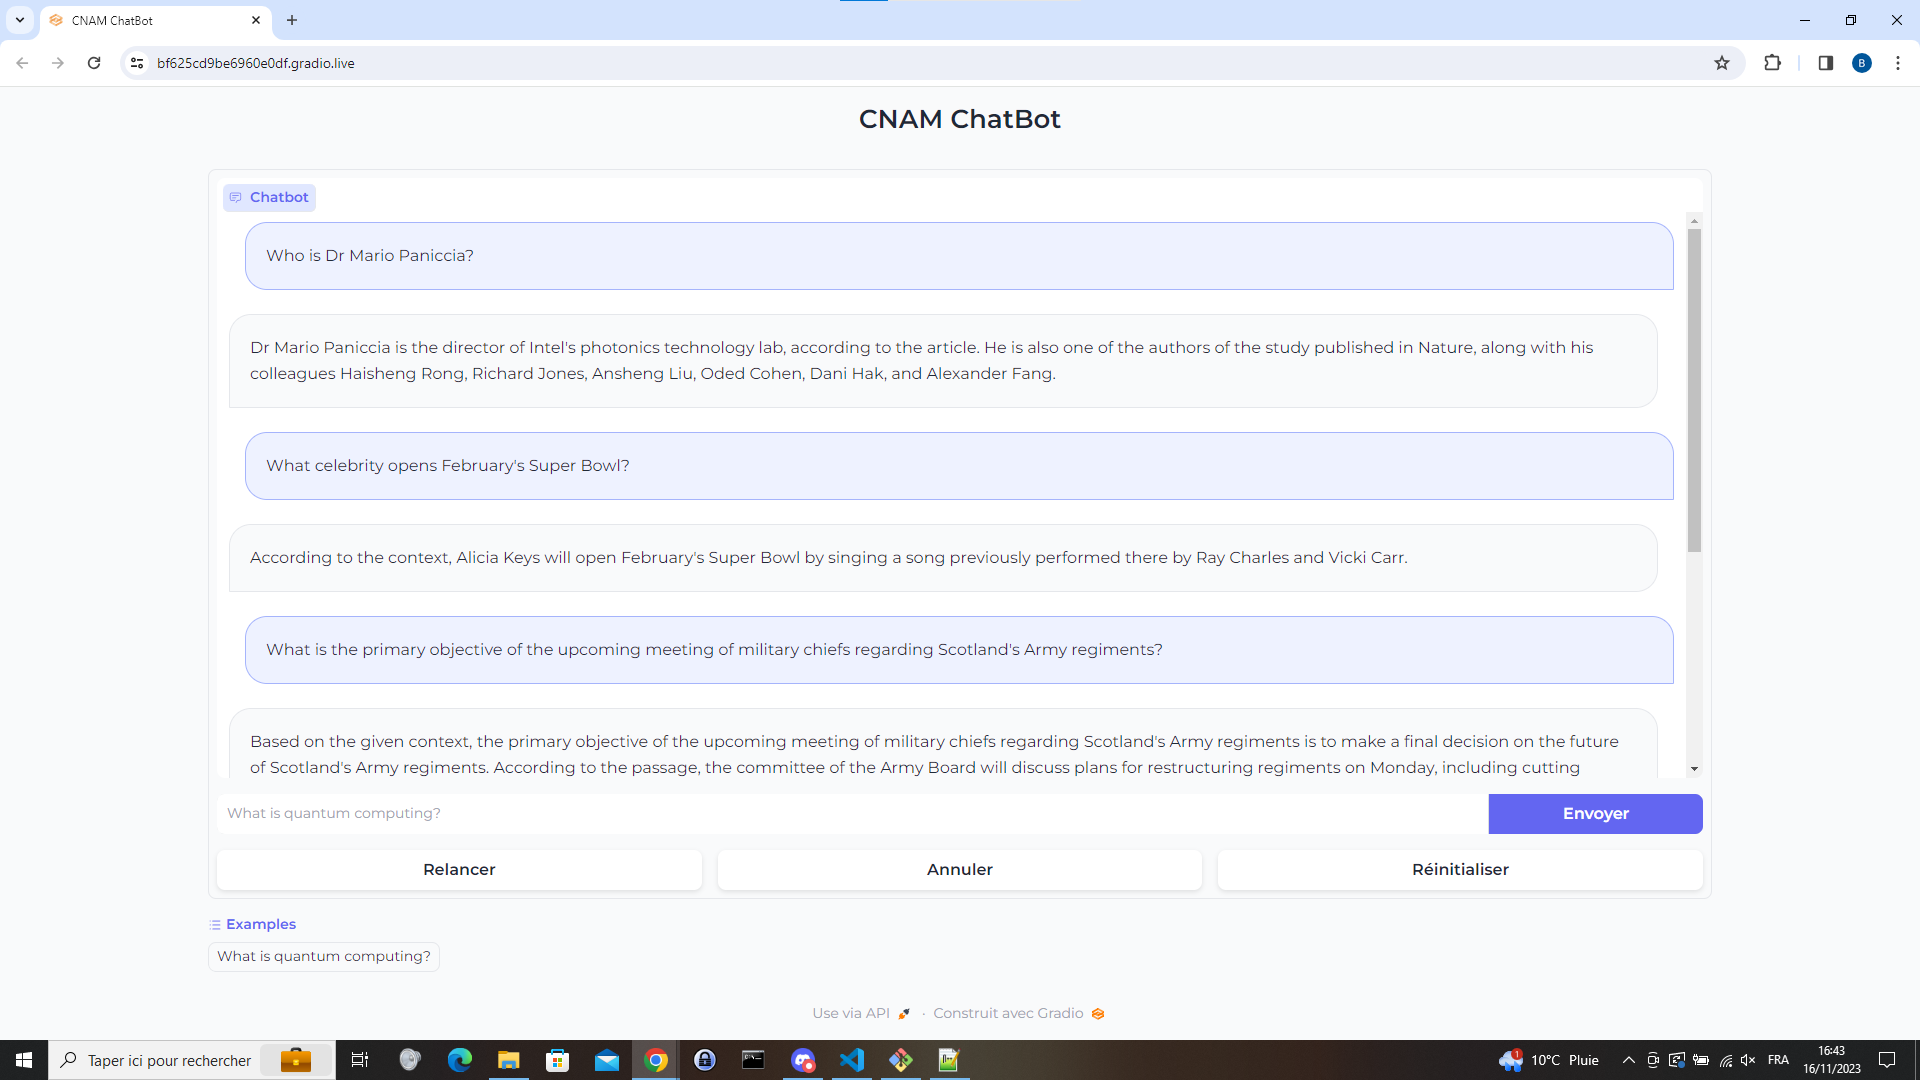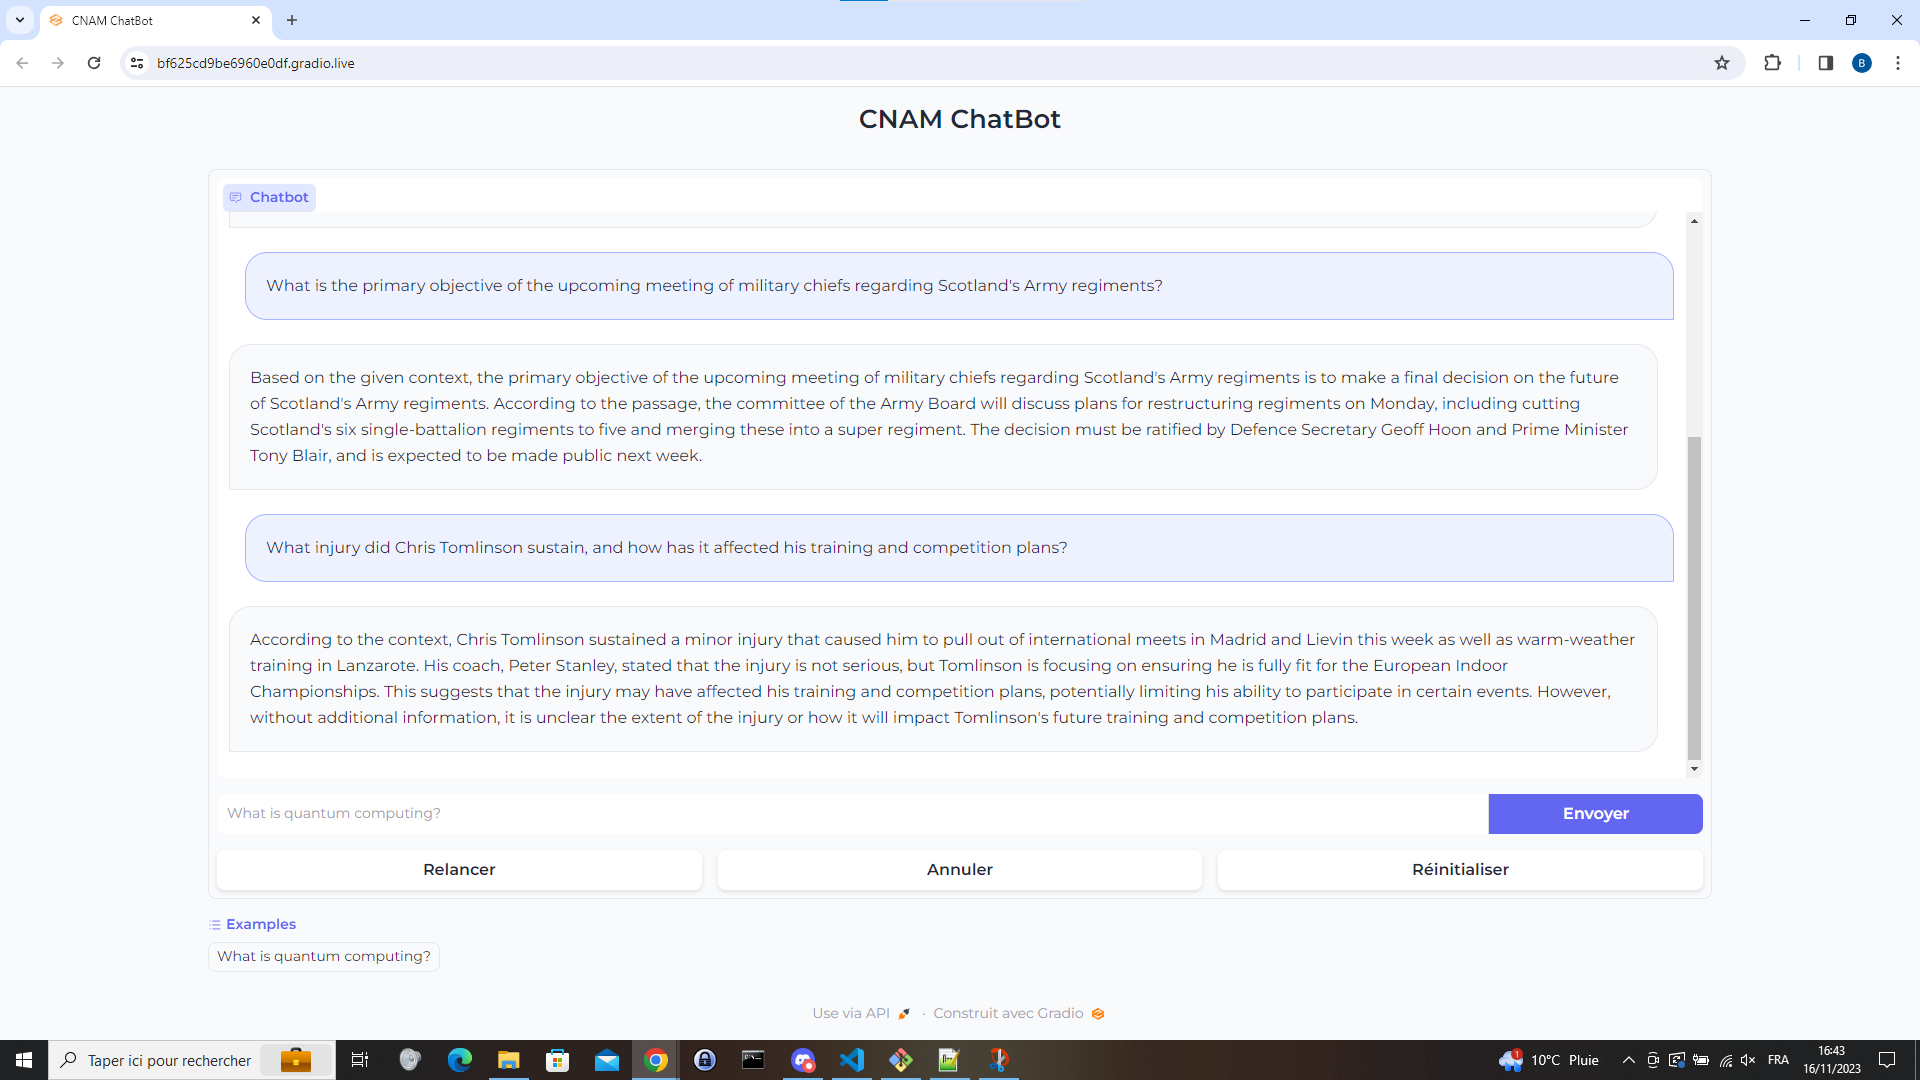

#### Exercice 5.

Modifier le `prompt_template` pour que le chatbot réponde en français.

In [16]:
prompt_template = """
[INST]
To act as a journalist, respond to the question using only elements from the context provided. Ensure that the response is solely based on the context without adding any external information. Responses should be in French.
When citing, include the relevant paragraphs from the context that directly contribute to your response.
[/INST]

[CONTEXT]
{context}
[/CONTEXT]

[QUESTION]
{question}
[/QUESTION]

[CITATION]
Please cite specific passages from the above context that were particularly relevant in answering the question.
[/CITATION]

[RESPONSE]
[/RESPONSE]
"""

prompt = PromptTemplate(template=prompt_template, input_variables=["context", "question"])